##### imports

In [1]:
import ingenos
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

##### set base directory for each data set

In [2]:
amp_base = "/afs/crc.nd.edu/group/BesanskyNGS/data05/comp_karyo/data/amplicon_sequencing"
oa_base = "/afs/crc.nd.edu/group/BesanskyNGS/data05/comp_karyo/data/open_array"

##### import SNP locations, as saved during the analysis of each data set

In [3]:
amp_SNPs = pd.read_csv(amp_base + "/amp_SNP_list.041320.csv")

amp_SNPs.head()

,label,assay
0,NaN,NaN
1,a,2L_20674783_a
2,a,2L_20726658_a
3,a,2L_20813877_a
4,a,2L_20995428_a


##### drop the first row, which is empty

In [4]:
amp_SNPs = amp_SNPs[1:]

amp_SNPs.head()

,label,assay
1,a,2L_20674783_a
2,a,2L_20726658_a
3,a,2L_20813877_a
4,a,2L_20995428_a
5,a,2L_21120275_a


In [5]:
amp_SNPs["chrom"] = amp_SNPs["assay"].str.split("_", expand=True)[0]
amp_SNPs["pos"] = amp_SNPs["assay"].str.split("_", expand=True)[1]
amp_SNPs["pos"] = amp_SNPs["pos"].astype(int)

amp_SNPs.head()

,label,assay,chrom,pos
1,a,2L_20674783_a,2L,20674783
2,a,2L_20726658_a,2L,20726658
3,a,2L_20813877_a,2L,20813877
4,a,2L_20995428_a,2L,20995428
5,a,2L_21120275_a,2L,21120275


##### repeat for the OpenArray data

In [6]:
oa_SNPs = pd.read_csv(oa_base + "/oa_SNP_list.041320.csv")

oa_SNPs.head()

,label,pos
0,NaN,NaN
1,a,20546192.0
2,a,20731296.0
3,a,20816241.0
4,a,21590819.0


In [7]:
oa_SNPs = oa_SNPs[1:]
oa_SNPs["pos"] = oa_SNPs["pos"].astype(int)

oa_SNPs.head()

,label,pos
1,a,20546192
2,a,20731296
3,a,20816241
4,a,21590819
5,a,21687929


##### combine the openarray and amplicon_sequencing results

In [8]:
oa_SNPs["type"] = "OA"
amp_SNPs["type"] = "GT-seq"

both = pd.concat([oa_SNPs, amp_SNPs[["label", "pos", "type"]]])

both.head()

,label,pos,type
1,a,20546192,OA
2,a,20731296,OA
3,a,20816241,OA
4,a,21590819,OA
5,a,21687929,OA


In [9]:
both["chrom"] = "2R"
both.loc[both["label"] == "a", "chrom"] = "2L"

##### add a column for the inversions
##### u inversions values are changed to d because they share a plot. similarly, c_col and c_gam values are changed to c.

In [10]:
both["inversion"] = both["label"]

both.loc[both["label"] == "u", "inversion"] = "d"
both.loc[both["label"] == "c_col", "inversion"] = "c"
both.loc[both["label"] == "c_gam", "inversion"] = "c"

In [11]:
dupes = both[["chrom","pos","label","inversion"]]\
[both[["chrom","pos","label","inversion"]].duplicated()]

dupes

,chrom,pos,label,inversion
22,2L,41966114,a,a
25,2R,15740978,j,j
27,2R,15743203,j,j
30,2R,15749248,j,j
59,2R,27282330,c_col,c
76,2R,30386671,c_col,c


##### plot the locations

In [12]:
both["inversion"].unique()

array(['a', 'j', 'b', 'c', 'd'], dtype=object)

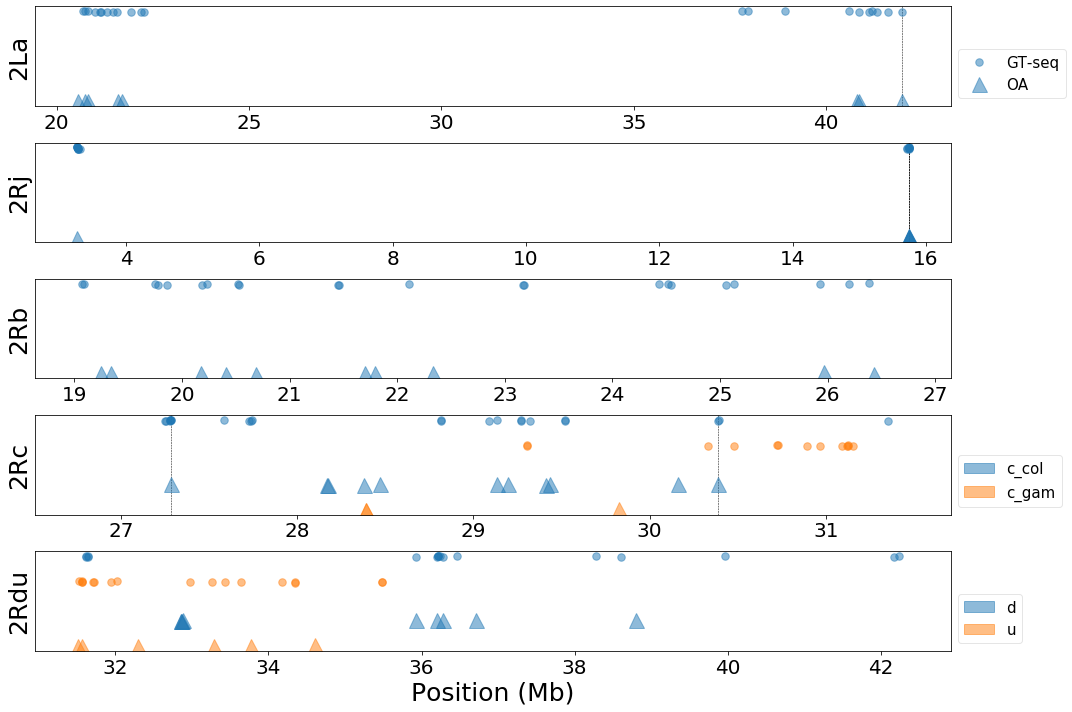

In [13]:
height_dict = {"GT-seq" : 0.5, "OA" : 0}

marker_dict = {"GT-seq" : ".", "OA" : "^"}

color_dict = {"c_col" : "C0", "c_gam" : "C1",
             "d" : "C0", "u" : "C1", "j" : "C0", "b" : "C0", "a" : "C0"}

offset_dict = {"c_col" : 0, "c_gam" : 0.2,
         "d" : 0, "u" : 0.2, "j" : 0, "b" : 0, "a" : 0}

fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (15, 10))

for i, ax in enumerate(axes):
        
    inversion = both["inversion"].unique()[i]

    full_name = "2R" + inversion

    if inversion == "a":

        full_name = "2La"
                
    inv_min = ingenos.inversionDict[full_name].proximal_start
    inv_max = ingenos.inversionDict[full_name].distal_end

    chunk = both.loc[both["inversion"] == inversion, :]

    if inversion == "d":

        inv_min = 31495381
        inv_max = 42375004

    x_offset = (inv_max - inv_min) * .05

    dupes_chunk = dupes.loc[dupes["inversion"] == inversion]

    for _, row in dupes_chunk.iterrows():

        ax.axvline(x = row["pos"], color = "k", linestyle = "--", lw = 0.5)

    for j, dtype in enumerate(chunk["type"].unique()):

        type_chunk = chunk.loc[chunk["type"] == dtype, :]

        height = height_dict[dtype]

        for k, label in enumerate(type_chunk["label"].unique()):

            label_chunk = type_chunk.loc[type_chunk["label"] == label, :]

            y_offset = offset_dict[label]

            ax.plot(label_chunk["pos"], 
                    np.random.uniform(height - y_offset - .005, height - y_offset + .005,
                                      [len(label_chunk)]), 
                    color = color_dict[label], 
                    linestyle = ' ',
                    marker = marker_dict[dtype], label = dtype, markersize=15, alpha = 0.5)

    ax.set_xlim(inv_min - x_offset, inv_max + x_offset)
    ax.ticklabel_format(useOffset=False, style="plain")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, 
                                                                 pos: '{x:,.0f}'.format(
                                                                     x=x/1000000)))
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    ax.set_ylabel((full_name), fontsize=25)

    if inversion == "c":

        inv_handles = list()

        for label in ["c_col", "c_gam"]:

            patch = matplotlib.patches.Patch(color = color_dict[label], label = label, 
                                             alpha = 0.5)
            inv_handles.append(patch)

        legend = ax.legend(handles = inv_handles, fontsize=15, fancybox=True, 
                           framealpha=0.5, bbox_to_anchor=(1, 0), loc = "lower left")

    if inversion == "d":

        inv_handles = list()

        for label in ["d", "u"]:

            patch = matplotlib.patches.Patch(color = color_dict[label], label = label, 
                                             alpha = 0.5)
            inv_handles.append(patch)

        legend = ax.legend(handles = inv_handles, fontsize=15, fancybox=True, 
                           framealpha = 0.5, bbox_to_anchor=(1, 0), loc = "lower left")

        ax.set_xlabel("Position (Mb)", fontsize=25)
        ax.set_ylabel("2Rdu", fontsize=25)

    if inversion == "a":
        
        handles, labels = ax.get_legend_handles_labels()
        
        ax.legend(handles[::-1], labels[::-1], fontsize = 15, fancybox=True, 
                       framealpha=0.5, bbox_to_anchor=(1, 0), loc = "lower left")
            
plt.tight_layout()

outString = ingenos.make_date_stamp(
    amp_base + "/results/location_of_target_SNPs")

#plt.savefig(outString)